In [11]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.utils import util, data_loaders
from src.utils.domain_split import hyperplane_split
from src.model import MLP
from src.train_test import fit_regr, test_regr

seed = npr.randint(10000)
# seed = 9871
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
df = pd.read_csv("../../data/regression/wine.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [13]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)
df[dom_idx].head()

Found random direction n = [ 0.27643806 -0.05208537  0.45151406 -0.45915714  0.22193517  0.05182454
 -0.18163997  0.19066456 -0.34511436 -0.51169766 -0.01408824  0.06127752]
Found split with ratio r = 0.20075046904315197


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [14]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_features = X_train.shape[1]
n_classes = 1
n_hidden_1 = 100
n_hidden_2 = 30
network = [n_hidden_1, n_hidden_2]
activation = 'relu'
n_epochs = 10000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size = 64

# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size, device)

### ReLU

Average Train MSE: 0.00026


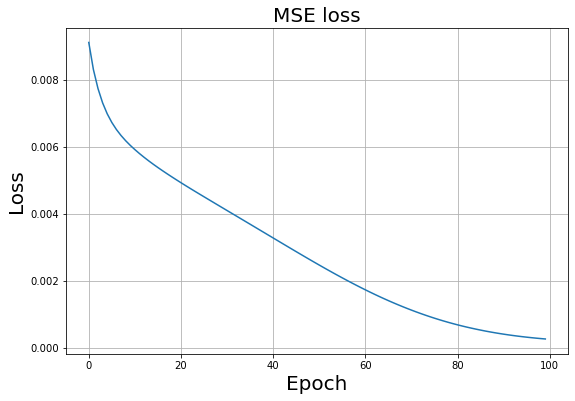

Average test MSE = 0.00084


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [15]:
model = MLP(n_features, 1, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_regr(model, loss_function, optimizer, train_loader, 
    n_epochs=100, verbose=1, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")  

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

### Abs

In [14]:
activation = 'abs'

In [15]:
model = MLP(n_features, 1, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
train_losses = fit_regr(model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                        verbose=1, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")
print(f"Total Train MSE: {len(X_train) * avg_train_loss:.5f}")

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

Training: Epoch 1: Average MSE Loss: 0.00505026
Training: Epoch 2: Average MSE Loss: 0.00356407
Training: Epoch 3: Average MSE Loss: 0.00300067
Training: Epoch 4: Average MSE Loss: 0.00258042
Training: Epoch 5: Average MSE Loss: 0.00222892
Training: Epoch 6: Average MSE Loss: 0.00191779
Training: Epoch 7: Average MSE Loss: 0.00163474
Training: Epoch 8: Average MSE Loss: 0.00137662
Training: Epoch 9: Average MSE Loss: 0.00114295
Training: Epoch 10: Average MSE Loss: 0.00093423
Training: Epoch 11: Average MSE Loss: 0.00075096
Training: Epoch 12: Average MSE Loss: 0.00059547
Training: Epoch 13: Average MSE Loss: 0.00046838
Training: Epoch 14: Average MSE Loss: 0.00036796
Training: Epoch 15: Average MSE Loss: 0.00029160
Training: Epoch 16: Average MSE Loss: 0.00023582
Training: Epoch 17: Average MSE Loss: 0.00019640
Training: Epoch 18: Average MSE Loss: 0.00016911
Training: Epoch 19: Average MSE Loss: 0.00015034
Training: Epoch 20: Average MSE Loss: 0.00013742
Training: Epoch 21: Average M

Training: Epoch 168: Average MSE Loss: 0.00005117
Training: Epoch 169: Average MSE Loss: 0.00005112
Training: Epoch 170: Average MSE Loss: 0.00005106
Training: Epoch 171: Average MSE Loss: 0.00005101
Training: Epoch 172: Average MSE Loss: 0.00005096
Training: Epoch 173: Average MSE Loss: 0.00005090
Training: Epoch 174: Average MSE Loss: 0.00005085
Training: Epoch 175: Average MSE Loss: 0.00005081
Training: Epoch 176: Average MSE Loss: 0.00005073
Training: Epoch 177: Average MSE Loss: 0.00005071
Training: Epoch 178: Average MSE Loss: 0.00005065
Training: Epoch 179: Average MSE Loss: 0.00005061
Training: Epoch 180: Average MSE Loss: 0.00005056
Training: Epoch 181: Average MSE Loss: 0.00005050
Training: Epoch 182: Average MSE Loss: 0.00005047
Training: Epoch 183: Average MSE Loss: 0.00005042
Training: Epoch 184: Average MSE Loss: 0.00005039
Training: Epoch 185: Average MSE Loss: 0.00005033
Training: Epoch 186: Average MSE Loss: 0.00005029
Training: Epoch 187: Average MSE Loss: 0.00005025


KeyboardInterrupt: 

In [17]:
avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   
print(f"Total test MSE: {len(X_test) * avg_train_loss:.5f}")

Average test MSE = 0.00007
Total test MSE: 0.07965


In [18]:
avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average OOD loss = 0.0018426714
Average OOD loss to train loss ratio:  35.398
Average OOD loss to test loss ratio:  27.314


In [31]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size, device)

    # Model setup
    model = MLP(n_features, 1, network, activation).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=1, early_stopping=True, return_losses=True) 
    test_loss = test_regr(model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Loss has stopped decreasing after epoch 152 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001394783
Average Test MSE Loss :  0.0032228815

Training on fold no. 2
Loss has stopped decreasing after epoch 179 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001291957
Average Test MSE Loss :  0.0037405792

Training on fold no. 3
Loss has stopped decreasing after epoch 169 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001569484
Average Test MSE Loss :  0.0030567419

Training on fold no. 4
Loss has stopped decreasing after epoch 164 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001339548
Average Test MSE Loss :  0.0009278679

Training on fold no. 5
Loss has stopped decreasing after epoch 145 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001395873
Average Test MSE Loss :  0.0016236231

Training on fold no. 6
Loss has stopped decreasing after epoch 129 (average of 

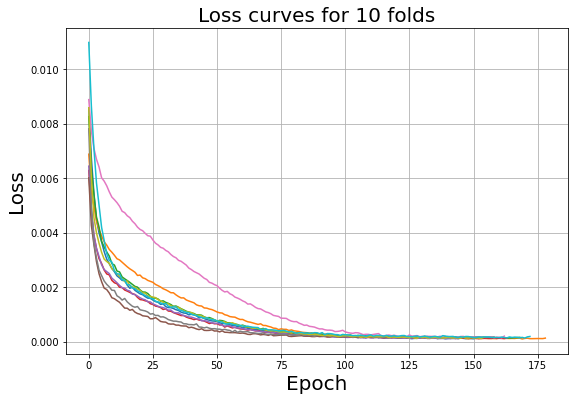

In [32]:
n_splits = 10
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("\nTrain losses:", train_losses)
print("\nTest losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() 
avg_test_loss_k_folds = test_losses.mean() 
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg total train loss over all folds: {len(X_train) * avg_train_loss_k_folds :.5f}")
print(f"\nAvg test loss over all folds: {avg_test_loss_k_folds :.5f}")
print(f"Avg total test loss over all folds: {len(X_test) * avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()